In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(0), float(1), int(50))
# The original data
one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)

# The trial that uses f+g'' to create the data (i.e. L*[f g]^T)
#one = torch.sin(train_x * (float(2) * math.pi)) - torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)

# The trial that uses f+g' to create the data (i.e. L*[f g]^T)
#one = torch.randn(train_x.size()) * float(0.02)

two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

train_y = torch.stack([one, two], int(-1))


In [3]:
train_y

tensor([[-0.0860,  0.9564],
        [ 0.2599,  0.9802],
        [-0.0564,  0.9614],
        [ 0.3655,  0.9350],
        [ 0.4931,  0.8745],
        [ 0.6004,  0.8352],
        [ 0.1941,  0.7571],
        [ 0.7334,  0.6395],
        [ 0.8591,  0.5313],
        [ 0.9666,  0.4422],
        [ 1.0076,  0.2739],
        [ 1.1110,  0.1704],
        [ 1.0319,  0.0528],
        [ 0.9458, -0.0783],
        [ 1.0496, -0.2657],
        [ 0.9083, -0.3507],
        [ 0.9968, -0.4780],
        [ 0.8700, -0.5810],
        [ 0.8317, -0.6759],
        [ 0.2707, -0.7572],
        [ 0.6449, -0.8503],
        [ 0.1393, -0.9252],
        [ 0.3088, -0.9445],
        [ 0.1987, -0.9667],
        [ 0.2234, -0.9946],
        [-0.0875, -1.0343],
        [-0.1507, -0.9438],
        [-0.4714, -0.9370],
        [-0.3132, -0.9140],
        [-0.5487, -0.8301],
        [-0.9102, -0.7458],
        [-0.5741, -0.6756],
        [-0.5715, -0.5943],
        [-0.9017, -0.4717],
        [-1.1798, -0.3562],
        [-0.9576, -0

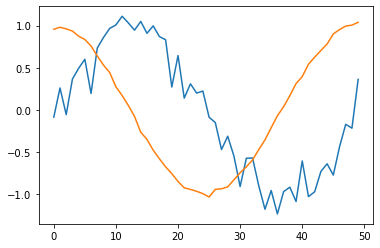

In [4]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [5]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, k2))
L = matrix(2, 2, (1, dx1, 0, 1))
R = matrix(2, 2, (1, 0, dx2, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[dx1*dx2*k2 + k1          dx1*k2]
[         dx2*k2              k2]

In [6]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, dx1, 0, 1))
        R = matrix(2, 2, (1, 0, dx2, 1))
        p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        kernel0 = gpytorch.kernels.RBFKernel()
        kernel1 = gpytorch.kernels.RBFKernel()
        kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0)
        #kernel2 = Diff_SE_kernel(var = 0, length=0)
        #self.covar_module = MatrixKernel([[kernel0, None], [None, kernel2]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel(), Diff_SE_kernel()]
List of all kernels: [RBFKernel(
  (raw_lengthscale_constraint): Positive()
), RBFKernel(
  (raw_lengthscale_constraint): Positive()
)]


In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(50)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

RuntimeError: Sizes of tensors must match except in dimension 1. Got 1 and 50 in dimension 0 (The offending index is 1)

In [ ]:
param_dict

In [ ]:
for parameter in model.named_parameters():
    print(parameter)

In [ ]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [ ]:
print(likelihood.noise)
print(likelihood.task_noises)

In [ ]:
for parameter in model.named_parameters():
    print(parameter)

In [ ]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(50)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(0), float(2), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


In [ ]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(3)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 8])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 8])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [ ]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

# Test Diffable SE Kernel

In [ ]:
X = torch.tensor([int(1), int(2), int(3)])
X

In [ ]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1)(int(v1), int(v2), lengthscale, variance))
cov_matr

In [ ]:
print(SE.diff(x1))
print(SE.diff(x1).diff(x2))

In [ ]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

In [ ]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [ ]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

In [ ]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [ ]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), None], [None, sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(diffed_SE_sage_matrix_kernel))] for j in range(len(X)*len(diffed_SE_sage_matrix_kernel))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(diffed_SE_sage_matrix_kernel)):
        for col in range(len(diffed_SE_sage_matrix_kernel)):
            # Blockwise
            cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = diffed_SE_sage_matrix_kernel[row][col].substitute(x1=int(v1), x2=int(v2), l=lengthscale, sigma=variance)
            # Interleaved
            #cov_matr[int(((i*len(diffed_SE_sage_matrix_kernel))+row)/(len(X)*len(diffed_SE_sage_matrix_kernel)))*2+row][int((i*len(diffed_SE_sage_matrix_kernel))+col)%(len(X)*len(diffed_SE_sage_matrix_kernel))] = float(diffed_SE_sage_matrix_kernel[row][col].substitute(x1=int(v1), x2=int(v2), l=lengthscale, sigma=variance))
cov_matr


In [ ]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

In [ ]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

In [ ]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [ ]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

In [ ]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [ ]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [ ]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

In [ ]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

In [ ]:
x = ['a', 'b', 'c']
y = x                 # x and y reference the same object
z = ['a', 'b', 'c']   # x and z reference different objects
#z


print(x is z)
z = x
print(x is z)
